# Mixed Domain

## Data

The pickle file contains a dictionary:
* x_<train/valid>: data point with 2 feature columns
* y_<train/valid>: label
* d_<train/valid>: domain

The train-valid split is:
* Train: 2400 datapoints
* Valid: 300 datapoints

In [1]:
import pickle
data = pickle.load(open("./data.pkl", "rb"))

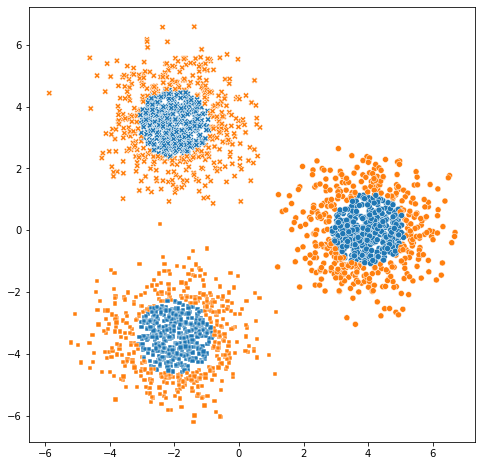

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x=data['x_train'][:, 0], y=data['x_train'][:, 1],
                hue=data['y_train'], style=data['d_train'], legend=False
)

plt.show()

## Assignment Specifications

* Goal: To create a multi-domain FFNN of 2 hidden layers (20, 10) with ReLU as activation function.
* Report accuracy performance stats on validation set for random seeds [0, 10, 1234, 99, 2021].
* Train each model for 30,000 epochs using Adam optimizer (LR: 1e-3).


# Question 1: Implement a basic FNN (multi-domain model training)

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0009894005488604307
INFO:util.loop:Validation loss: 0.039157889783382416
INFO:util.loop:Train acc: 99.95834%
INFO:util.loop:Validation acc: 99.66667%


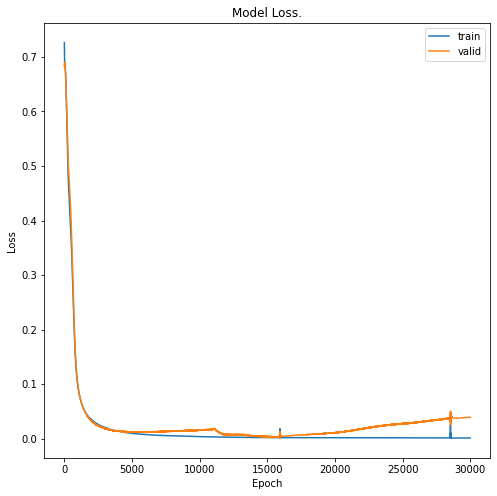

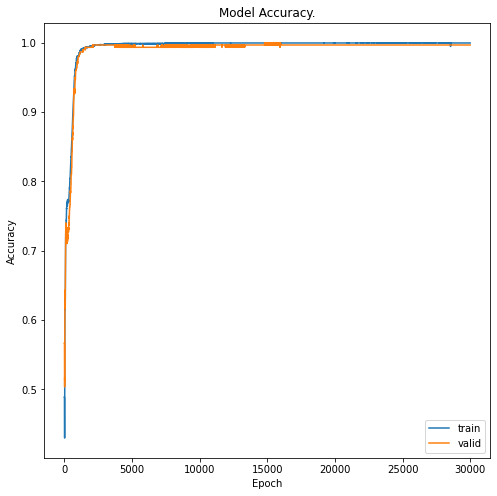

In [3]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
model = FFNN(random_state=0)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
model, _ = train(data, model, epochs, batch_size, optimizer, plot=True)

In [4]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    print(f"\n\nRandom State {random_state}:")
    _, valid_acc = train(data, model, epochs, batch_size, optimizer, validate=True, plot=False, logfile=f"q1_random_state_{random_state}")
    valid_accuracies.append(valid_acc)



Random State 0:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0009894005488604307
INFO:util.loop:Validation loss: 0.039157889783382416
INFO:util.loop:Train acc: 99.95834%
INFO:util.loop:Validation acc: 99.66667%




Random State 10:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.000570417963899672
INFO:util.loop:Validation loss: 0.06213418394327164
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.33333%




Random State 1234:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00040898623410612345
INFO:util.loop:Validation loss: 0.01920529082417488
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.66667%




Random State 99:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0009839736158028245
INFO:util.loop:Validation loss: 0.08278196305036545
INFO:util.loop:Train acc: 99.95834%
INFO:util.loop:Validation acc: 99.33333%




Random State 2021:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00033661077031865716
INFO:util.loop:Validation loss: 0.055419351905584335
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.66667%


In [23]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.533334% +/- 0.001825740117187435


# Creating a dictionary of different domain data

Needs to be created for the following questions.

In [3]:
Data = {}
for domain in set(data['d_train']):
    Data[domain] = {}
    for data_set in ['train', 'valid']:
        index = data[f'd_{data_set}']==domain
        for key in data.keys():
            if data_set in key: Data[domain][key] = data[key][index]

# Question 2: Implement a multi-domain model using knowledge distillation

## Teacher Model Training



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.410443165805191e-05
INFO:util.loop:Validation loss: 0.03757632523775101
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


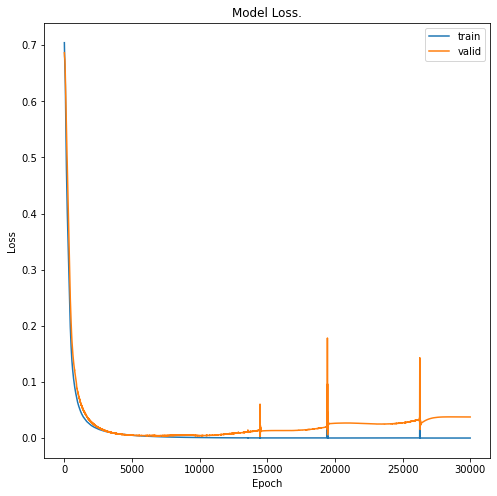

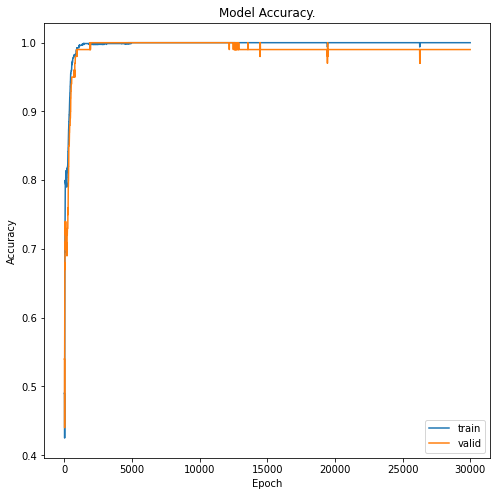



 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.7752357457065955e-05
INFO:util.loop:Validation loss: 0.04767947643995285
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


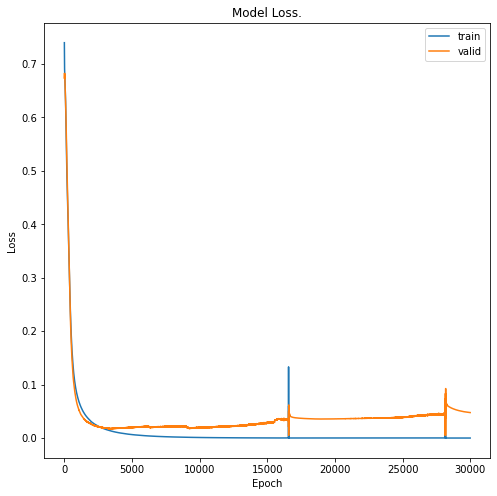

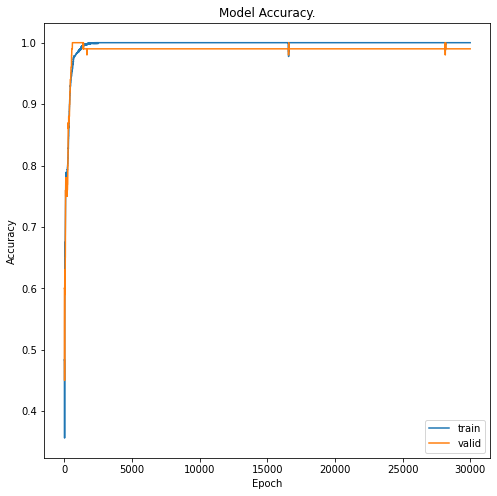



 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.001145931426435709
INFO:util.loop:Validation loss: 1.4950436707295012e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%


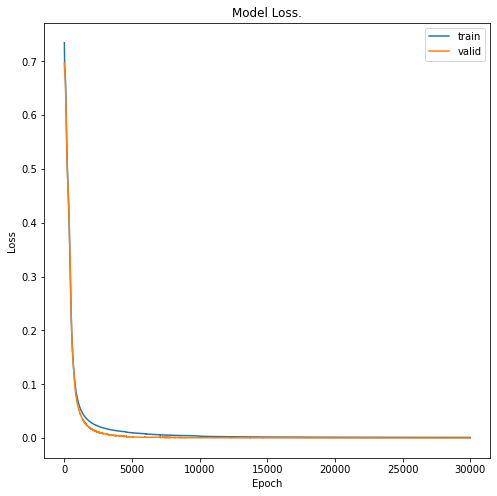

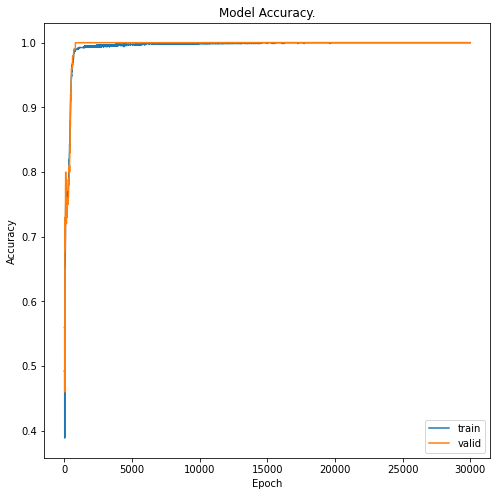

In [12]:
import torch
from util.model import FFNN
from util.loop import train

Teacher_Model = {}
for domain in set(data['d_train']):
    epochs = 30000
    batch_size = len(Data[domain]['x_train'])   # batch gradient descent
    Teacher_Model[domain] = FFNN(random_state=0)
    optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
    print(f"\n\n Teacher Model Training for Domain {domain}")
    Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, plot=True)

## Storing logits offline infered from trained teacher models

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for domain in set(data['d_train']):
    with torch.no_grad(): 
        Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
        Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

## Student Training

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.06376051902770996
INFO:util.loop:Validation loss: 0.11788445711135864
INFO:util.loop:Train acc: 99.95833%
INFO:util.loop:Validation acc: 99.33333%


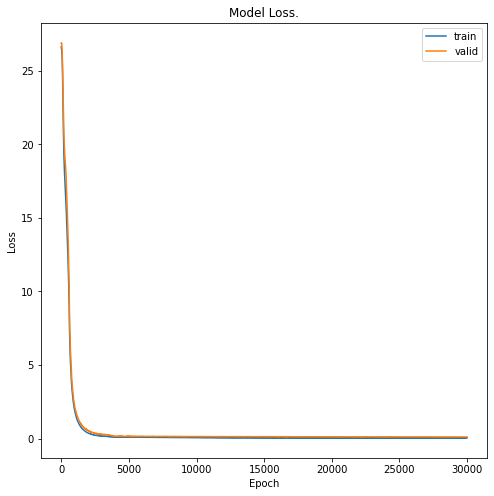

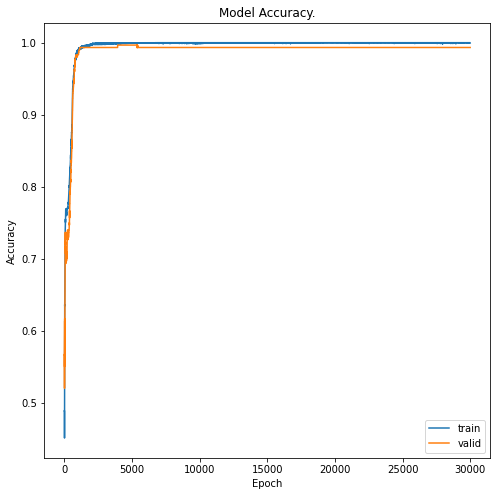

In [14]:
import torch
from util.model import FFNN
from util.loop import student_train

epochs = 30000
batch_size_ratio = 1.0   # batch gradient descent
alpha = 0.5
T = 9.0
Student_Model = FFNN(random_state=0)
optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
Student_Model, _ = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, plot=True)

## Complete run using 5 random states

In [17]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:

    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain}")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"q2_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.5
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, 
                                             plot=False, logfile=f"q2_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.410443165805191e-05
INFO:util.loop:Validation loss: 0.03757632523775101
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.7752357457065955e-05
INFO:util.loop:Validation loss: 0.04767947643995285
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.001145931426435709
INFO:util.loop:Validation loss: 1.4950436707295012e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.06376051902770996
INFO:util.loop:Validation loss: 0.11788445711135864
INFO:util.loop:Train acc: 99.95833%
INFO:util.loop:Validation acc: 99.33333%




 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0010667259339243174
INFO:util.loop:Validation loss: 0.0716656967997551
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 9.75549210124882e-06
INFO:util.loop:Validation loss: 0.11051397025585175
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.7866588677861728e-05
INFO:util.loop:Validation loss: 8.22540684453088e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0874667763710022
INFO:util.loop:Validation loss: 0.18324311077594757
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 99.33333%




 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0004323266330175102
INFO:util.loop:Validation loss: 6.166849925648421e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 7.022562203928828e-05
INFO:util.loop:Validation loss: 0.042277250438928604
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.6331377891183365e-06
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0881943330168724
INFO:util.loop:Validation loss: 0.17010563611984253
INFO:util.loop:Train acc: 99.95833%
INFO:util.loop:Validation acc: 99.66667%




 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.004191495478153229
INFO:util.loop:Validation loss: 0.00012974214041605592
INFO:util.loop:Train acc: 99.75000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.018911881255917e-05
INFO:util.loop:Validation loss: 0.2259918749332428
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.295421215123497e-05
INFO:util.loop:Validation loss: 2.384185515680315e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.10922367125749588
INFO:util.loop:Validation loss: 0.1513102799654007
INFO:util.loop:Train acc: 99.74999%
INFO:util.loop:Validation acc: 99.66667%




 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014328345423564315
INFO:util.loop:Validation loss: 0.1367752104997635
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1578087111274726e-07
INFO:util.loop:Validation loss: 0.004002104047685862
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0027667596004903316
INFO:util.loop:Validation loss: 5.602821318007045e-08
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.07246891409158707
INFO:util.loop:Validation loss: 0.10682094842195511
INFO:util.loop:Train acc: 99.91667%
INFO:util.loop:Validation acc: 99.33333%


In [18]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.466667% +/- 0.001825740117187435


# Question 3: Ways to improve

## Method 1: Increasing alpha value to shift weightage to soft label training

In [19]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"q31_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.81
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, 
                                             plot=False, logfile=f"q31_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.410443165805191e-05
INFO:util.loop:Validation loss: 0.03757632523775101
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.7752357457065955e-05
INFO:util.loop:Validation loss: 0.04767947643995285
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.001145931426435709
INFO:util.loop:Validation loss: 1.4950436707295012e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.051823828369379044
INFO:util.loop:Validation loss: 0.15902179479599
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.66667%




 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0010667259339243174
INFO:util.loop:Validation loss: 0.0716656967997551
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 9.75549210124882e-06
INFO:util.loop:Validation loss: 0.11051397025585175
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.7866588677861728e-05
INFO:util.loop:Validation loss: 8.22540684453088e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.17120979726314545
INFO:util.loop:Validation loss: 0.31855714321136475
INFO:util.loop:Train acc: 99.83333%
INFO:util.loop:Validation acc: 99.33333%




 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0004323266330175102
INFO:util.loop:Validation loss: 6.166849925648421e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 7.022562203928828e-05
INFO:util.loop:Validation loss: 0.042277250438928604
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.6331377891183365e-06
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.13779814541339874
INFO:util.loop:Validation loss: 0.28784695267677307
INFO:util.loop:Train acc: 99.91667%
INFO:util.loop:Validation acc: 99.66667%




 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.004191495478153229
INFO:util.loop:Validation loss: 0.00012974214041605592
INFO:util.loop:Train acc: 99.75000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.018911881255917e-05
INFO:util.loop:Validation loss: 0.2259918749332428
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.295421215123497e-05
INFO:util.loop:Validation loss: 2.384185515680315e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.14540092647075653
INFO:util.loop:Validation loss: 0.18297328054904938
INFO:util.loop:Train acc: 99.79166%
INFO:util.loop:Validation acc: 99.66667%




 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014328345423564315
INFO:util.loop:Validation loss: 0.1367752104997635
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1578087111274726e-07
INFO:util.loop:Validation loss: 0.004002104047685862
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0027667596004903316
INFO:util.loop:Validation loss: 5.602821318007045e-08
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.13753868639469147
INFO:util.loop:Validation loss: 0.1903700977563858
INFO:util.loop:Train acc: 99.91667%
INFO:util.loop:Validation acc: 99.33333%


In [20]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.533334% +/- 0.001825740117187435


## Method 2: Annealing Knowledge Distillation

We just noted that training with high weightage on loss from soft labels is effective (from Q3: Method 1). Annealing temperature value would allow the student to learn from flatter convex curvatures (non-convex here considered as a combination of convex landscapes), there by starting from a reduced differences in the multiple domain functions, i.e., adapting from the common feature learning.

The solution is adapted from the following reference. Instead of training with annealing T=1 steps and then fine-tuning with CE, alpha weighting is implemented to do it simultaneously.

_Ref: Jafari, A., Rezagholizadeh, M., Sharma, P. and Ghodsi, A., 2021, April. Annealing Knowledge Distillation. 
       In Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics: 
       Main Volume (pp. 2493-2504)._



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.410443165805191e-05
INFO:util.loop:Validation loss: 0.03757632523775101
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.7752357457065955e-05
INFO:util.loop:Validation loss: 0.04767947643995285
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.001145931426435709
INFO:util.loop:Validation loss: 1.4950436707295012e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 568.5689086914062
INFO:util.loop:Validation loss: 536.834228515625
INFO:util.loop:Train acc: 98.91667%
INFO:util.loop:Validation acc: 99.33333%


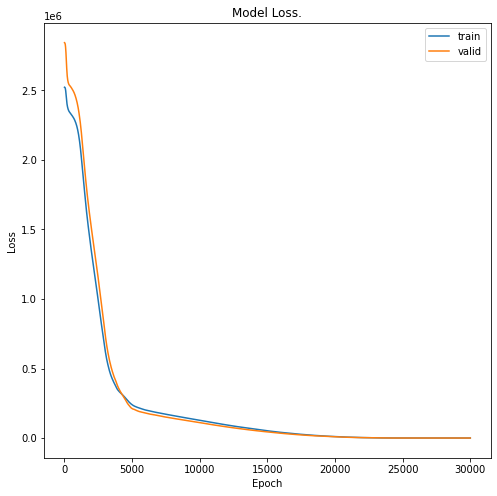

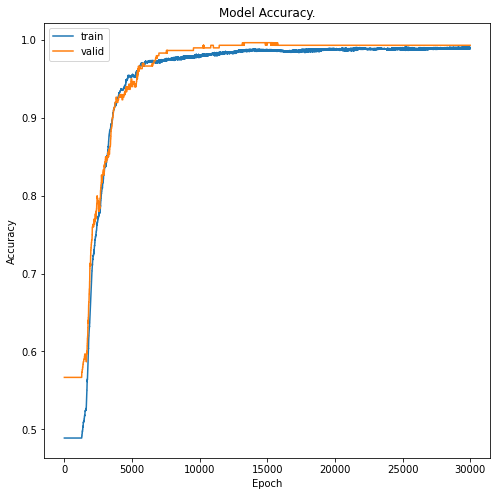



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0010667259339243174
INFO:util.loop:Validation loss: 0.0716656967997551
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 9.75549210124882e-06
INFO:util.loop:Validation loss: 0.11051397025585175
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.7866588677861728e-05
INFO:util.loop:Validation loss: 8.22540684453088e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 530.7229614257812
INFO:util.loop:Validation loss: 552.8456420898438
INFO:util.loop:Train acc: 98.50000%
INFO:util.loop:Validation acc: 98.66667%


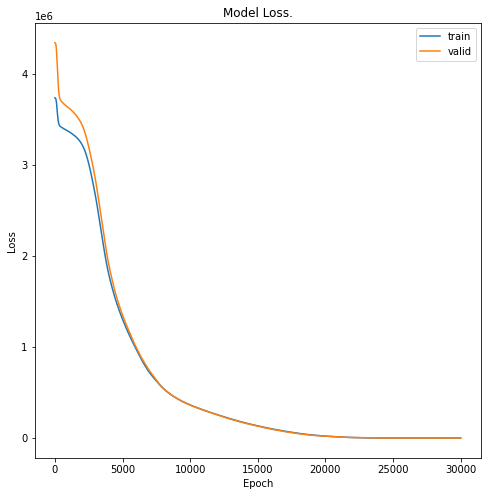

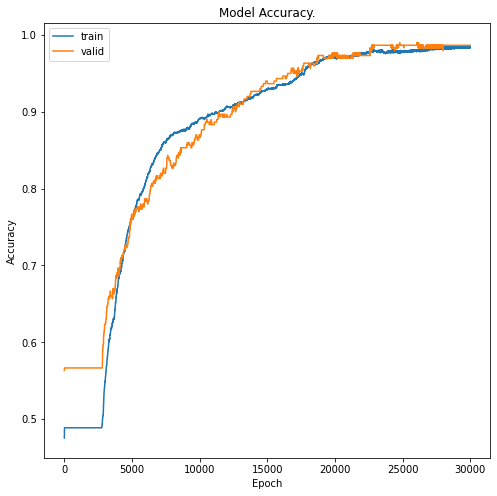



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0004323266330175102
INFO:util.loop:Validation loss: 6.166849925648421e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 7.022562203928828e-05
INFO:util.loop:Validation loss: 0.042277250438928604
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.6331377891183365e-06
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 584.6520385742188
INFO:util.loop:Validation loss: 1059.09375
INFO:util.loop:Train acc: 97.16666%
INFO:util.loop:Validation acc: 98.00000%


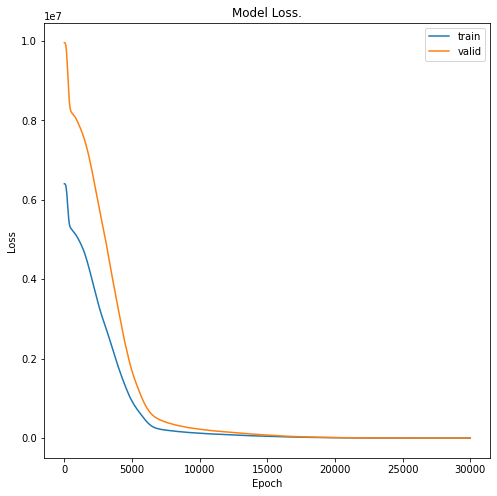

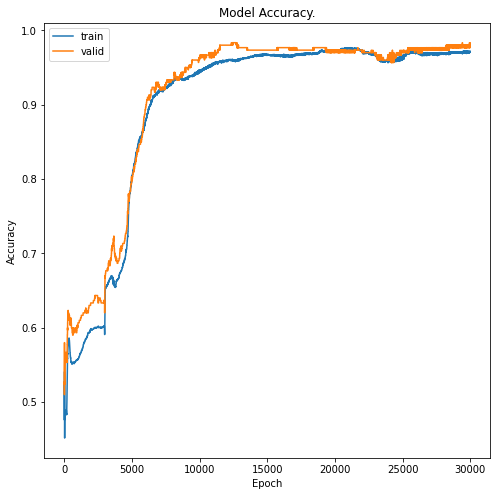



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.004191495478153229
INFO:util.loop:Validation loss: 0.00012974214041605592
INFO:util.loop:Train acc: 99.75000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.018911881255917e-05
INFO:util.loop:Validation loss: 0.2259918749332428
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.295421215123497e-05
INFO:util.loop:Validation loss: 2.384185515680315e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 250.13011169433594
INFO:util.loop:Validation loss: 435.4584655761719
INFO:util.loop:Train acc: 95.79166%
INFO:util.loop:Validation acc: 96.66666%


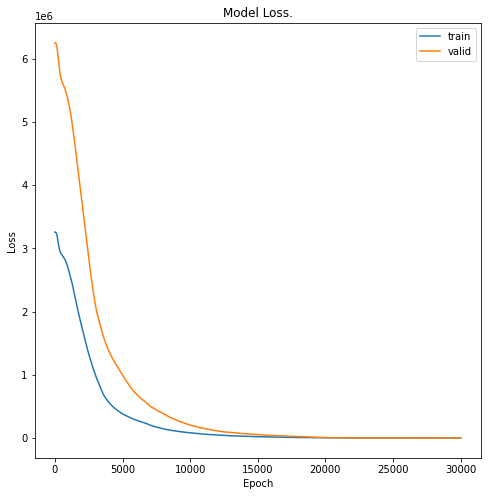

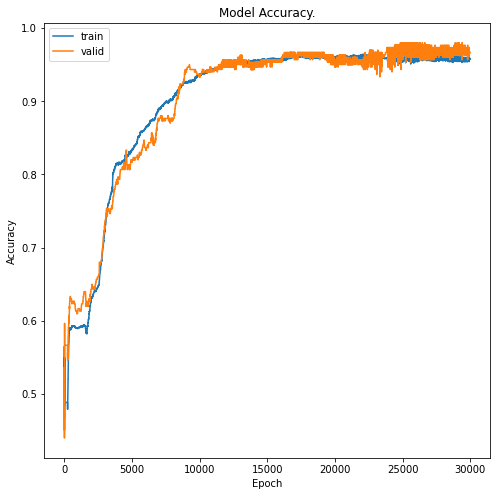



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014328345423564315
INFO:util.loop:Validation loss: 0.1367752104997635
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1578087111274726e-07
INFO:util.loop:Validation loss: 0.004002104047685862
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0027667596004903316
INFO:util.loop:Validation loss: 5.602821318007045e-08
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 353.8838195800781
INFO:util.loop:Validation loss: 424.2203063964844
INFO:util.loop:Train acc: 97.83333%
INFO:util.loop:Validation acc: 98.33333%


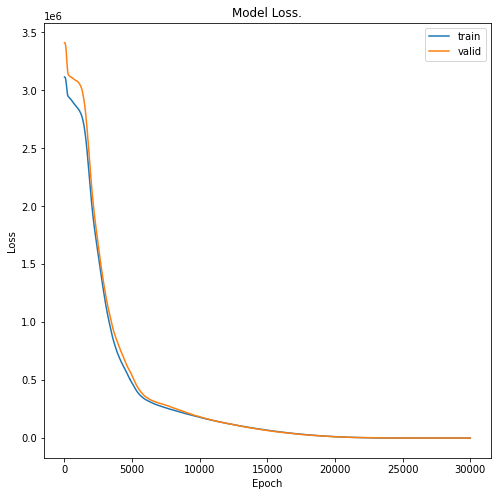

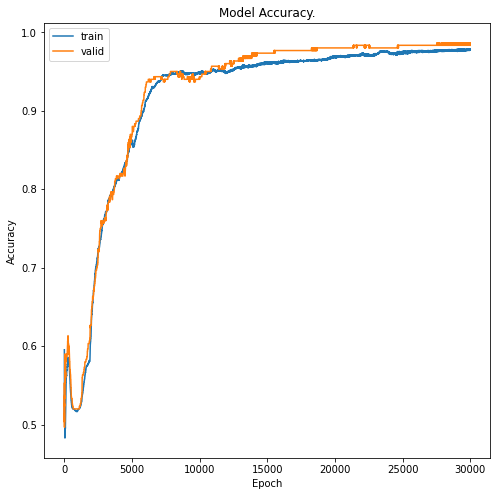

In [8]:
import torch
from util.model import FFNN
from util.loop import train, student_train_KD_annealing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"q32_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Annealing Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.6
    T_max = 9
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train_KD_annealing(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T_max, 
                                                          plot=True, logfile=f"q32_student_random_state_{random_state}_{T_max}")

    valid_accuracies.append(valid_acc)

In [9]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 98.199998% +/- 0.009888279330567337
